# **Task 01**
# **Time Series Analysis of Ethereum (ETH/USDT) Market Projections using ARIMA**

# Step 1: Install required libraries

In [ ]:

!pip install yfinance pandas matplotlib seaborn statsmodels pmdarima --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00


# Step 2: Import libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings("ignore")

# Step 3: Data Collection & Preparation

In [ ]:
eth_data = yf.download("ETH-USD", start="2020-01-01", end="2024-12-31")
eth_data.reset_index(inplace=True)

# Keep required columns and preprocess
eth = eth_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
eth['Date'] = pd.to_datetime(eth['Date'])
eth.set_index('Date', inplace=True)
eth = eth.dropna()

# Show basic info
print("Data shape:", eth.shape)
eth.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Data shape: (1826, 5)


Price,Open,High,Low,Close,Volume
Ticker,ETH-USD,ETH-USD,ETH-USD,ETH-USD,ETH-USD
Date,,,,,
2020-01-01,129.630661,132.835358,129.198288,130.802002,7935230330
2020-01-02,130.820038,130.820038,126.954910,127.410179,8032709256
2020-01-03,127.411263,134.554016,126.490021,134.171707,10476845358
2020-01-04,134.168518,136.052719,133.040558,135.069366,7430904515
2020-01-05,135.072098,139.410202,135.045624,136.276779,7526675353


# Step 4: Exploratory Data Analysis (EDA)

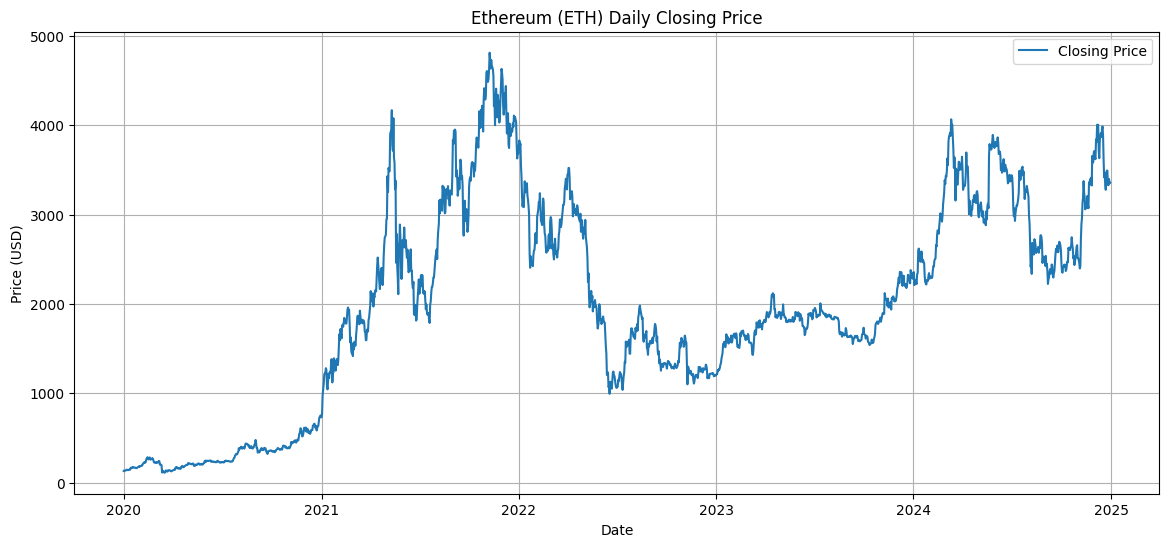

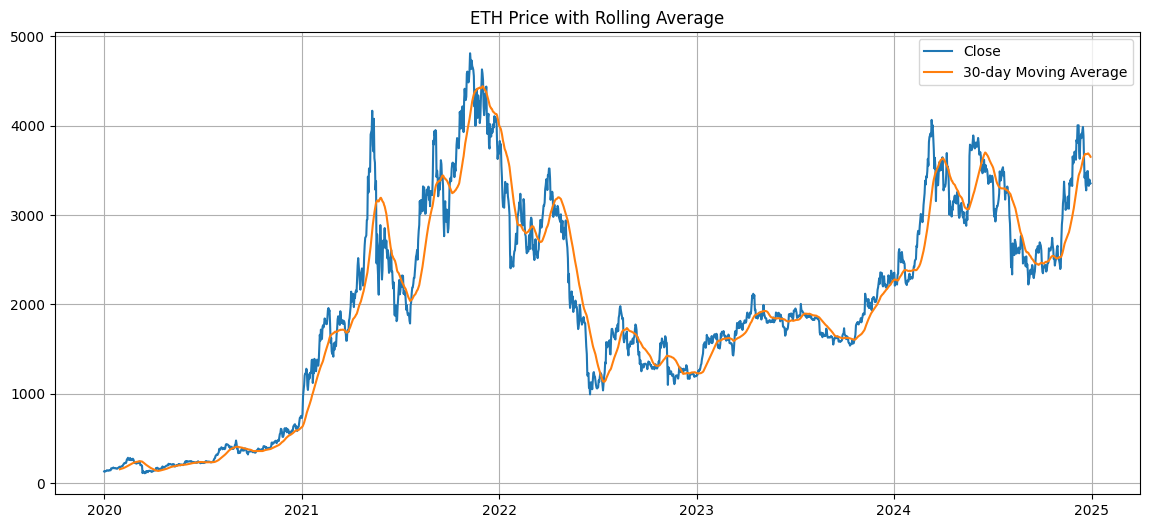

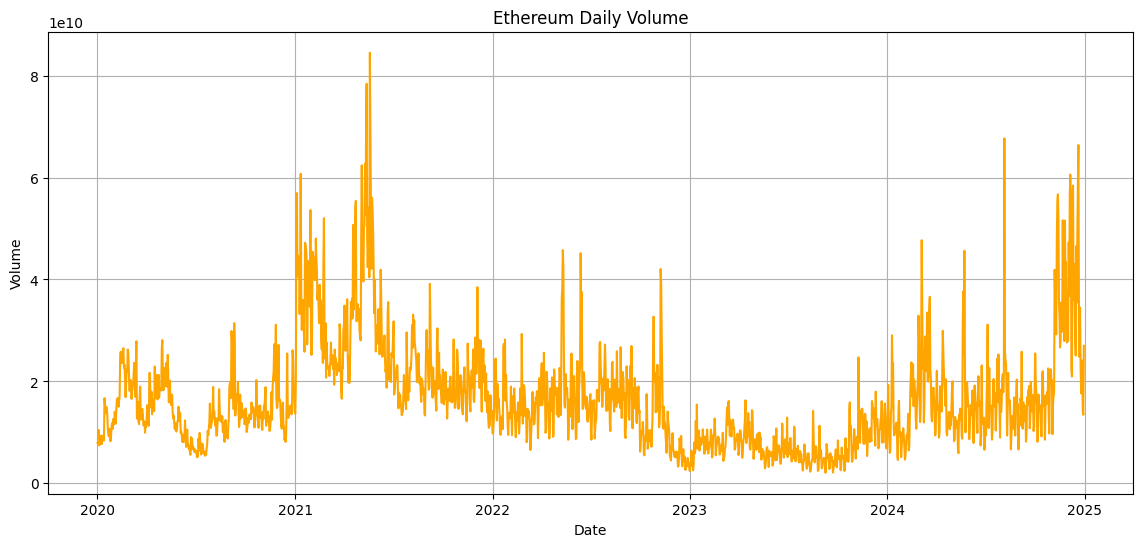

In [ ]:

# 1. Line plot of closing price
plt.figure(figsize=(14,6))
plt.plot(eth['Close'], label='Closing Price')
plt.title("Ethereum (ETH) Daily Closing Price")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.show()

# 2. Rolling Mean
eth['Rolling_Mean'] = eth['Close'].rolling(window=30).mean()

plt.figure(figsize=(14,6))
plt.plot(eth['Close'], label='Close')
plt.plot(eth['Rolling_Mean'], label='30-day Moving Average')
plt.title("ETH Price with Rolling Average")
plt.legend()
plt.grid(True)
plt.show()

# 3. Volume trend
plt.figure(figsize=(14,6))
plt.plot(eth['Volume'], color='orange')
plt.title("Ethereum Daily Volume")
plt.xlabel("Date")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


# Step 5: Stationarity Testing with ADF

In [ ]:

def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("✅ Data is stationary")
    else:
        print("❌ Data is not stationary")

print("ADF Test on Closing Price:")
adf_test(eth['Close'])

# Differencing if non-stationary
eth_diff = eth['Close'].diff().dropna()

print("\nADF Test on Differenced Data:")
adf_test(eth_diff)


ADF Test on Closing Price:
ADF Statistic: -1.9388719525648033
p-value: 0.31400116530566735
❌ Data is not stationary

ADF Test on Differenced Data:
ADF Statistic: -16.72498773248956
p-value: 1.3983797761380692e-29
✅ Data is stationary


# Step 6: ACF & PACF plots

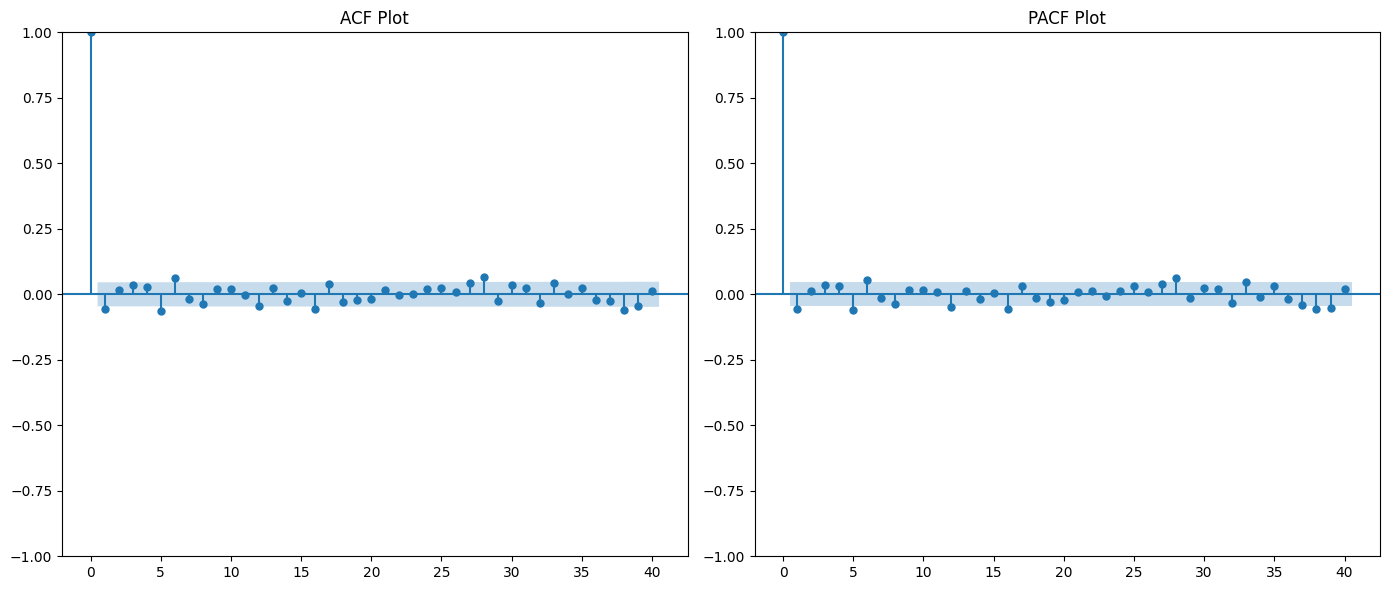

In [ ]:

plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plot_acf(eth_diff, ax=plt.gca(), lags=40)
plt.title("ACF Plot")

plt.subplot(1,2,2)
plot_pacf(eth_diff, ax=plt.gca(), lags=40)
plt.title("PACF Plot")
plt.tight_layout()
plt.show()


# Step 7: ARIMA Model Training

In [ ]:
# (Assuming p=1, d=1, q=1)
model = ARIMA(eth['Close'], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                ETH-USD   No. Observations:                 1826
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -10858.888
Date:                Sun, 20 Apr 2025   AIC                          21723.777
Time:                        17:37:24   BIC                          21740.305
Sample:                    01-01-2020   HQIC                         21729.874
                         - 12-30-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1592      0.245     -0.651      0.515      -0.639       0.320
ma.L1          0.1052      0.247      0.425      0.671      -0.380       0.590
sigma2      8641.2504    123.189     70.146      0.0

# Step 8: Model Evaluation

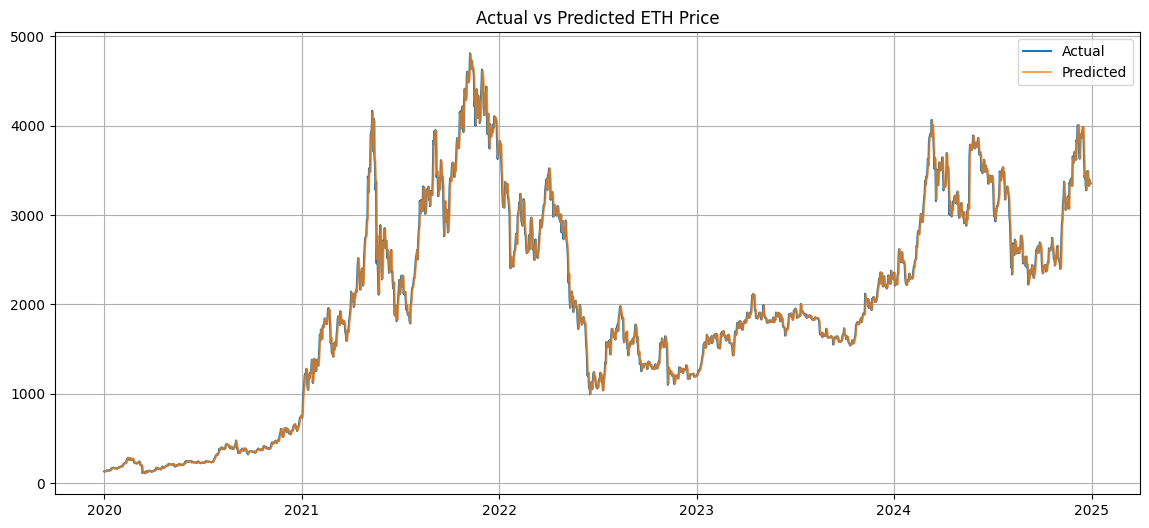

✅ RMSE: 92.86394303200964
✅ MAPE: 2.95%


In [ ]:
eth['Forecast'] = model_fit.predict(start=1, end=len(eth)-1, typ='levels')

# Plot Actual vs Predicted
plt.figure(figsize=(14,6))
plt.plot(eth['Close'], label='Actual')
plt.plot(eth['Forecast'], label='Predicted', alpha=0.7)
plt.title("Actual vs Predicted ETH Price")
plt.legend()
plt.grid(True)
plt.show()

# Evaluation Metrics
rmse = np.sqrt(mean_squared_error(eth['Close'][1:], eth['Forecast'][1:]))
mape = mean_absolute_percentage_error(eth['Close'][1:], eth['Forecast'][1:])

print(f"✅ RMSE: {rmse}")
print(f"✅ MAPE: {mape*100:.2f}%")


# Step 9: Forecasting Next 30 Days

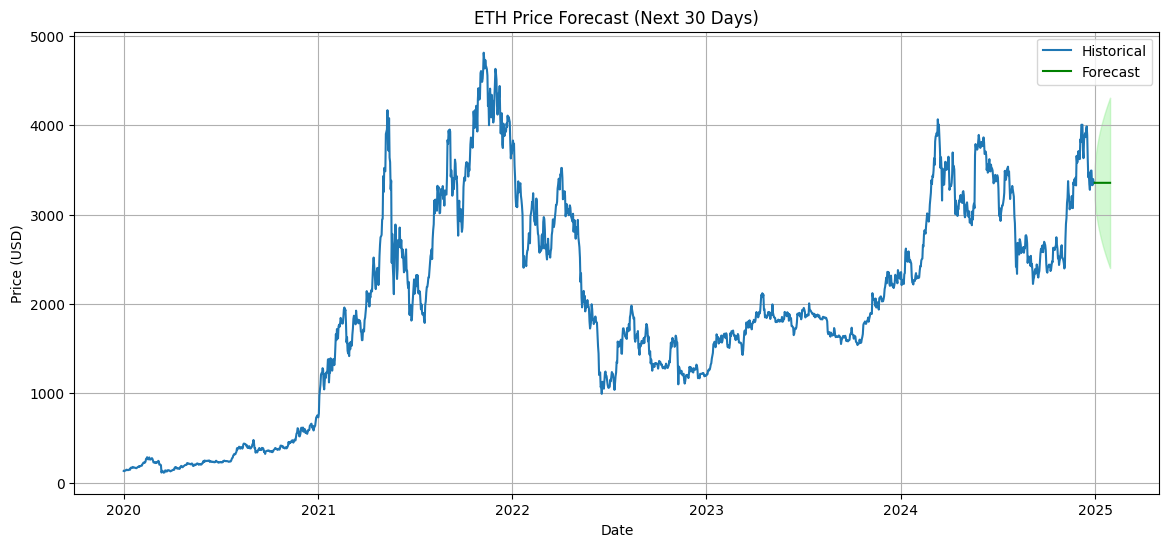

In [ ]:

forecast = model_fit.get_forecast(steps=30)
forecast_index = pd.date_range(start=eth.index[-1] + pd.Timedelta(days=1), periods=30)

forecast_df = pd.DataFrame({
    'Forecast': forecast.predicted_mean,
    'Lower CI': forecast.conf_int().iloc[:, 0],
    'Upper CI': forecast.conf_int().iloc[:, 1]
}, index=forecast_index)

# Plot future forecast
plt.figure(figsize=(14,6))
plt.plot(eth['Close'], label='Historical')
plt.plot(forecast_df['Forecast'], label='Forecast', color='green')
plt.fill_between(forecast_df.index, forecast_df['Lower CI'], forecast_df['Upper CI'], color='lightgreen', alpha=0.4)
plt.title("ETH Price Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.show()
